In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr, AckleyPathConstr, BraninConstr, HyperEllipsoidConstr, LevyConstr
from benchmark_functions import MichalewiczConstr, RastriginConstr, SchwefelConstr, StyblinskiTangConstr
from benchmark_functions import DiscreteAckleyConstr, DiscreteDoubleWellConstr, DiscreteMichalewiczConstr
from benchmark_functions import LinearFunnelConstr, NarrowFunnelConstr

from olympus.surfaces import Surface

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_surface(surface, ax=None, N=100, fs=10, fmt='%d', nlines=8):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=fs, labels_fmt=fmt, n_contour_lines=nlines, contour_alpha=0.8, cbar=False, cmap='RdBu')
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)

In [3]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)

def plot_min_trace_mean(data, ax=None, color=None, label=None, categorical=False, shift=0.0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    if categorical is True:
        traces_min = get_traces_min_for_categorical(data) - shift
    else:
        traces_min = get_traces_min(data) - shift
    
    mean = np.nanmean(traces_min, axis=0)
    stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    ax.fill_between(x, y1=mean-stde, y2=mean+stde, alpha=0.2, color=color)
    ax.plot(x, mean-stde, color=color, linewidth=1, alpha=0.5)
    ax.plot(x, mean+stde, color=color, linewidth=1, alpha=0.5)
    
    
def plot_timings_mean(data, ax=None, color=None, label=None, categorical=False, shift=0.0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    timings = []
    for df in data:
        timings.append(df['timings'].values)
    timings = np.array(timings)
    
    mean = np.nanmean(timings, axis=0)
    stde = np.nanstd(timings, axis=0, ddof=1) / np.sqrt(np.shape(timings)[0] - 1)
    x = range(1, np.shape(timings)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)

    
def plot_min_trace_median(data, ax=None, color=None, label=None, nboots=1000):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_min = get_traces_min(data, replace_nan=True)

    median = np.median(traces_min, axis=0)
    q100, q75, q25, q0 = bootstrapped_iqr(traces_min, nboots=1000)
    x = range(1, np.shape(traces_min)[1] + 1, 1)

    ax.plot(x, median, color=color, label=label)
    ax.fill_between(x, y1=q25, y2=q75, alpha=0.2, color=color)
    ax.fill_between(x, y1=q0, y2=q100, alpha=0.2, color=color)
    
    
def bootstrapped_iqr(traces, nboots=100):
    boot_medians = []
    for b in range(nboots):
        boot_idx = np.random.randint(low=0, high=traces.shape[0], size=traces.shape[0])
        boot_traces = traces[boot_idx]
        boot_median = np.median(boot_traces, axis=0)
        boot_medians.append(boot_median)
        
    q75, q25 = np.percentile(np.array(boot_medians), [75 ,25], axis=0)
    q100 = np.max(traces, axis=0)
    q0 = np.min(traces, axis=0)
    return q100, q75, q25, q0


def plot_trace_sigle(folder, ax, categorical=False, color='k', label='', shift=0.0):
    with open(f'{folder}/results.pkl', 'rb') as content:
        data = pickle.load(content)
    plot_min_trace_mean(data, ax=ax, color=color, label=label, categorical=categorical, shift=shift)
    
    
def get_avg_timings(data_grad, data_gene):
    timings_grad = []
    for df in data_grad:
        timings_grad.extend(df['timings'].values[10:]) 
    timings_gene = []
    for df in data_gene:
        timings_gene.extend(df['timings'].values[10:])

    avg_time_grad, avg_time_gene = np.mean(timings_grad), np.mean(timings_gene)
    std_time_grad, std_time_gene = np.std(timings_grad)/np.sqrt(len(timings_grad)), np.std(timings_gene)/np.sqrt(len(timings_gene))
    
    return ((avg_time_grad, std_time_grad), (avg_time_gene, std_time_gene))

## Load results

In [4]:
# dejong
with open(f'dejong_const_fca-0.2_ei/results_genetic.pkl', 'rb') as content:
    data_dejong_const_fca_ei = pickle.load(content)
with open(f'dejong_const_fca-0.2_ucb/results_genetic.pkl', 'rb') as content:
    data_dejong_const_fca_ucb = pickle.load(content)
    
with open(f'dejong_const_fwa_ei/results_gradient.pkl', 'rb') as content:
    data_dejong_const_fwa_ei = pickle.load(content)
with open(f'dejong_const_fwa_ucb/results_gradient.pkl', 'rb') as content:
    data_dejong_const_fwa_ucb = pickle.load(content)
    
with open(f'dejong_unconst_ei/results_gradient.pkl', 'rb') as content:
    data_dejong_unconst_ei = pickle.load(content)
with open(f'dejong_unconst_ucb/results_gradient.pkl', 'rb') as content:
    data_dejong_unconst_ucb = pickle.load(content)
    
# catmichalewicz
with open(f'catmichalewicz_const_fca-0.2_ei/bkp-results.pkl', 'rb') as content:
    data_michal_const_fca_ei = pickle.load(content)
with open(f'catmichalewicz_const_fca-0.2_ucb/bkp-results.pkl', 'rb') as content:
    data_michal_const_fca_ucb = pickle.load(content)
    
with open(f'catmichalewicz_const_fwa_ei/results.pkl', 'rb') as content:
    data_michal_const_fwa_ei = pickle.load(content)
with open(f'catmichalewicz_const_fwa_ucb/results.pkl', 'rb') as content:
    data_michal_const_fwa_ucb = pickle.load(content)
    
with open(f'catmichalewicz_unconst_ei/results.pkl', 'rb') as content:
    data_michal_unconst_ei = pickle.load(content)
with open(f'catmichalewicz_unconst_ucb/results.pkl', 'rb') as content:
    data_michal_unconst_ucb = pickle.load(content)
    

print(f'DEJONG UNCONST\tEI: {len(data_dejong_unconst_ei)} UCB: {len(data_dejong_unconst_ucb)}')
print(f'CATMICHALEWICZ UNCONST\tEI: {len(data_michal_unconst_ei)} UCB: {len(data_michal_unconst_ucb)}')


print(f'DEJONG CONST FWA\tEI: {len(data_dejong_const_fwa_ei)} UCB: {len(data_dejong_const_fwa_ucb)}')
print(f'CATMICHALEWICZ CONST FWA\tEI: {len(data_michal_const_fwa_ei)} UCB: {len(data_michal_const_fwa_ucb)}')

print(f'DEJONG CONST FCA\tEI: {len(data_dejong_const_fca_ei)} UCB: {len(data_dejong_const_fca_ucb)}')
print(f'CATMICHALEWICZ CONST FCA\tEI: {len(data_michal_const_fca_ei)} UCB: {len(data_michal_const_fca_ucb)}')

DEJONG UNCONST	EI: 40 UCB: 40
CATMICHALEWICZ UNCONST	EI: 40 UCB: 40
DEJONG CONST FWA	EI: 40 UCB: 40
CATMICHALEWICZ CONST FWA	EI: 40 UCB: 40
DEJONG CONST FCA	EI: 40 UCB: 40
CATMICHALEWICZ CONST FCA	EI: 17 UCB: 33


In [5]:
# unpack the categorical results --> # evals to get to best

dicts_unconst = {'num_evals': [], 'acqf': []}
for d in data_michal_unconst_ei:
    dicts_unconst['num_evals'].append(d.shape[0])
    dicts_unconst['acqf'].append('ei')
for d in data_michal_unconst_ucb:
    dicts_unconst['num_evals'].append(d.shape[0])
    dicts_unconst['acqf'].append('ucb')
df_unconst = pd.DataFrame(dicts_unconst)   
    
dicts_const_fwa = {'num_evals': [], 'acqf': []}
for d in data_michal_const_fwa_ei:
    dicts_const_fwa['num_evals'].append(d.shape[0])
    dicts_const_fwa['acqf'].append('ei')
for d in data_michal_const_fwa_ucb:
    dicts_const_fwa['num_evals'].append(d.shape[0])
    dicts_const_fwa['acqf'].append('ucb')
df_const_fwa = pd.DataFrame(dicts_const_fwa)   
    
dicts_const_fca = {'num_evals': [], 'acqf': []}
for d in data_michal_const_fca_ei:
    dicts_const_fca['num_evals'].append(d.shape[0])
    dicts_const_fca['acqf'].append('ei')
for d in data_michal_const_fca_ucb:
    dicts_const_fca['num_evals'].append(d.shape[0])
    dicts_const_fca['acqf'].append('ucb')
df_const_fca = pd.DataFrame(dicts_const_fca)   
    

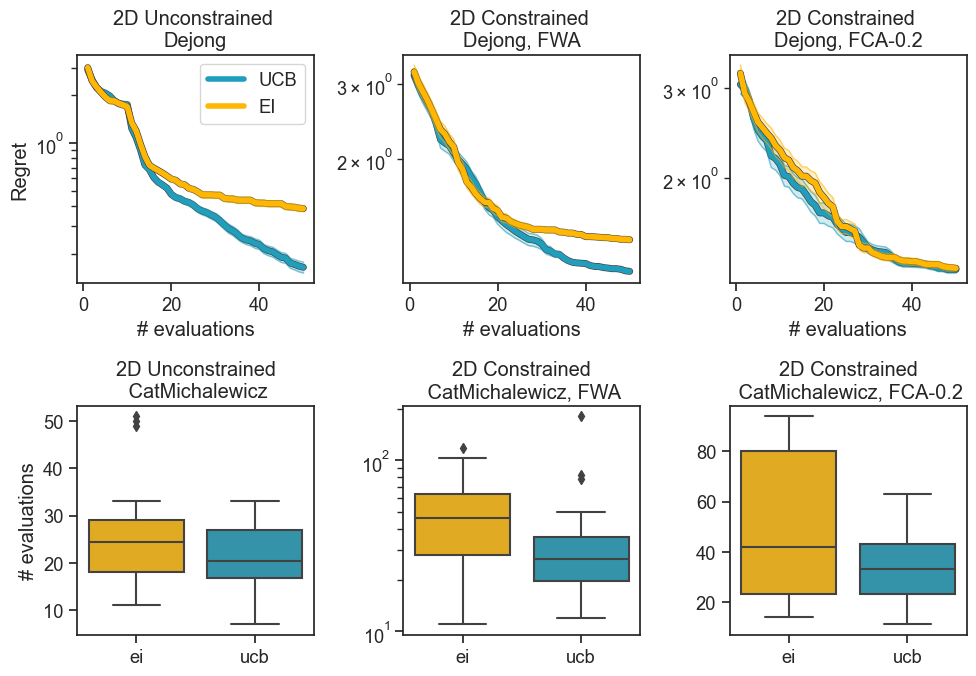

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

#-----------------
# DEJONG UNCONST
#----------------

shift = 0.0
plot_min_trace_mean(data_dejong_unconst_ucb, ax=axes[0,0], color='#219ebc', label='UCB', shift=shift)
plot_min_trace_mean(data_dejong_unconst_ei, ax=axes[0,0], color='#ffb703', label='EI', shift=shift)

axes[0,0].set_yscale('log')
axes[0,0].legend(loc='upper right')
axes[0,0].set_ylabel('Regret')
axes[0,0].set_xlabel('# evaluations')
axes[0,0].set_title('2D Unconstrained \nDejong')

#-----------------
# DEJONG CONST FWA
#-----------------

surface = DejongConstr()
shift = surface.minima[0]['value']
plot_min_trace_mean(data_dejong_const_fwa_ucb, ax=axes[0,1], color='#219ebc', label='UCB', shift=shift)
plot_min_trace_mean(data_dejong_const_fwa_ei, ax=axes[0,1], color='#ffb703', label='EI', shift=shift)

axes[0,1].set_yscale('log')
axes[0,1].set_xlabel('# evaluations')
axes[0,1].set_title('2D Constrained \nDejong, FWA')


#----------------------
# DEJONG CONST FCA-0.2
#----------------------

surface = DejongConstr()
shift = surface.minima[0]['value']
plot_min_trace_mean(data_dejong_const_fca_ucb, ax=axes[0,2], color='#219ebc', label='UCB', shift=shift)
plot_min_trace_mean(data_dejong_const_fca_ei, ax=axes[0,2], color='#ffb703', label='EI', shift=shift)

axes[0,2].set_yscale('log')
axes[0,2].set_xlabel('# evaluations')
axes[0,2].set_title('2D Constrained \nDejong, FCA-0.2')



#------------------------
# CATMICHALEWICZ UNCONST
#------------------------

mypal = {"ei": "#ffb703", "ucb": "#219ebc"}

sns.boxplot(data=df_unconst, x='acqf', y='num_evals', ax=axes[1,0], palette=mypal)
axes[1,0].set_ylabel('# evaluations')
axes[1,0].set_xlabel('')
axes[1,0].set_title('2D Unconstrained\n CatMichalewicz')

#--------------------------
# CATMICHALEWICZ CONST FWA
#--------------------------

sns.boxplot(data=df_const_fwa, x='acqf', y='num_evals', ax=axes[1,1], palette=mypal)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[1,1].set_title('2D Constrained\n CatMichalewicz, FWA')
axes[1,1].set_yscale('log')

#--------------------------
# CATMICHALEWICZ CONST FCA
#--------------------------

sns.boxplot(data=df_const_fca, x='acqf', y='num_evals', ax=axes[1,2], palette=mypal)
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')
axes[1,2].set_title('2D Constrained\n CatMichalewicz, FCA-0.2')


plt.tight_layout()

plt.savefig('ei_vs_ucb_compare.png', dpi=300)

NameError: name 'data_hype_filter' is not defined

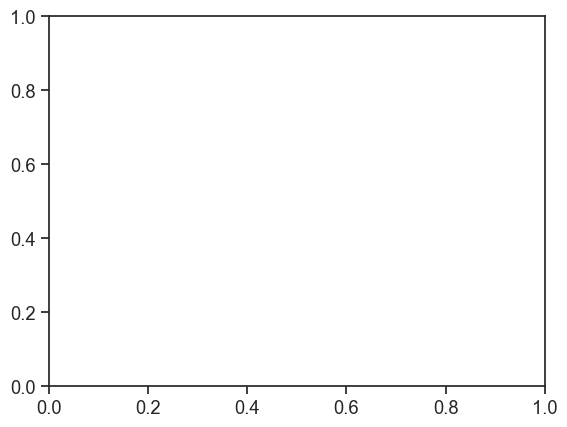

In [14]:
fig, ax  = plt.subplots()

#-------------------
# HYPERELLIPS FIA-1
#-------------------

surface = HyperEllipsoidConstr()
shift = surface.minima[0]['value']
plot_min_trace_mean(data_hype_filter, ax=ax, color='#219ebc', label='FIA-1 filter', shift=shift)
plot_min_trace_mean(data_hype_nofilter, ax=ax, color='#ffb703', label='FIA-1 nofilter', shift=shift)

ax.set_ylabel('Regret')
ax.set_xlabel('# evaluations')
ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_title('2D Constrained Hyperellipsoid')

plt.tight_layout()
plt.savefig('hyperellips_filter.png', dpi=300)

In [6]:
print('\nUnconstrained')
print(f'avg time gradient : {round(timings_unconst[0][0],3)} +/- {round(timings_unconst[0][1],3)}')
print(f'avg time genetic : {round(timings_unconst[1][0],3)} +/- {round(timings_unconst[1][1],3)}')

print('\nConstrained FCA-0.2')
print(f'avg time gradient : {round(timings_const_02[0][0],3)} +/- {round(timings_const_02[0][1],3)}')
print(f'avg time genetic : {round(timings_const_02[1][0],3)} +/- {round(timings_const_02[1][1],3)}')

print('\nConstrained FCA-0.5')
print(f'avg time gradient : {round(timings_const_05[0][0],3)} +/- {round(timings_const_05[0][1],3)}')
print(f'avg time genetic : {round(timings_const_05[1][0],3)} +/- {round(timings_const_05[1][1],3)}')

print('\nConstrained FCA-0.8')
print(f'avg time gradient : {round(timings_const_08[0][0],3)} +/- {round(timings_const_08[0][1],3)}')
print(f'avg time genetic : {round(timings_const_08[1][0],3)} +/- {round(timings_const_08[1][1],3)}')


Unconstrained
avg time gradient : 0.207 +/- 0.002
avg time genetic : 2.219 +/- 0.001

Constrained FCA-0.2
avg time gradient : 70.198 +/- 3.182
avg time genetic : 11.031 +/- 0.016

Constrained FCA-0.5
avg time gradient : 234.428 +/- 9.268
avg time genetic : 9.118 +/- 0.263

Constrained FCA-0.8
avg time gradient : 64.736 +/- 3.332
avg time genetic : 9.877 +/- 0.248
